The purpose of this notebook is to use the May trip data to see which scooters are ending and starting at bus stops during rush hour and which are not, so we can see where there are a large amount of scooters near bus stops and not near bus stops and use this info to get the optimal number of scooters in this area.

Import needed packages

In [11]:
from shapely.geometry import Point
from shapely.geometry import LineString
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from folium.plugins import HeatMap

Get the promise zone shape file

In [12]:
promise_zone = gpd.read_file('../data/MDHA_Promise_Zones/promise_zone.json')
promise_zone.head( )

OBJECTID  ZONE_ID    SHAPE_STAr     SHAPE_STLe  \
0         1        1  1.053728e+08   49364.601403   
1         2        2  7.670585e+07   45226.018917   
2         3        3  2.985488e+08   75207.067487   
3         4        4  2.713638e+08   74348.596054   
4         5        5  3.928178e+08  106661.712102   

                                            geometry  
0  POLYGON ((-86.76297 36.19364, -86.76297 36.193...  
1  POLYGON ((-86.77838 36.14889, -86.77823 36.148...  
2  POLYGON ((-86.70771 36.16723, -86.70758 36.166...  
3  POLYGON ((-86.74735 36.13036, -86.74728 36.130...  
4  POLYGON ((-86.78490 36.23358, -86.78452 36.232...

In [66]:
may_trips = pd.read_pickle('../data/may_trip.pkl')
may_trips.head()

pubTimeStamp  companyName tripRecordNum         sumdID  \
0 2019-05-01 00:00:55.423            0       BRD2134   Powered9EAJL   
1 2019-05-01 00:03:33.147            1          LFT5  Powered296631   
2 2019-05-01 00:05:55.570            0       BRD2168   Powered7S2UU   
3 2019-05-01 00:05:55.570            0       BRD2166   PoweredZIIVX   
4 2019-05-01 00:05:55.570            0       BRD2165   PoweredJ7MB3   

   tripDuration  tripDistance  startDate        startTime    endDate  \
0        3.0000     958.00528 2019-05-01  00:00:20.460000 2019-05-01   
1        1.7156    1371.39112 2019-05-01  00:01:50.090000 2019-05-01   
2        3.0000    2296.58800 2019-05-01  00:03:47.363333 2019-05-01   
3        3.0000    1200.78744 2019-05-01  00:04:21.386666 2019-05-01   
4        2.0000     351.04988 2019-05-01  00:04:27.796666 2019-05-01   

           endTime  startLatitude  startLongitude  endLatitude  endLongitude  \
0  00:02:52.346666       36.15710       -86.80360     36.15660     -86.80670   
1  00:03:33.026666       36.15797       -86.77896     36.16054     -86.77689   
2  00:07:13.596666       36.15470       -86.78180     36.15650     -86.78680   
3  00:06:59.176666       36.14940       -86.77950     36.15310     -86.77960   
4  00:06:23.150000       36.17780       -86.78660     36.17740     -86.78760   

                                           tripRoute  
0  [[36.157235,-86.803612],[36.157235,-86.80362],...  
1  [[36.15797,-86.77896],[36.15795,-86.77873],[36...  
2     [[36.155068,-86.782124],[36.156597,-86.78675]]  
3  [[36.149741,-86.779344],[36.149741,-86.779327]...  
4  [[36.177699,-86.786477],[36.177711,-86.786469]...

Add geometry fields for the start and end points.

In [67]:
may_trips['startGeometry'] = may_trips.apply(lambda x: Point((x.startLongitude,
                                                             x.startLatitude)), 
                                                                    axis=1)

may_trips['endGeometry'] = may_trips.apply(lambda x: Point((x.endLongitude,
                                                             x.endLatitude)), 
                                                                    axis=1)

may_trips.head()

pubTimeStamp  companyName tripRecordNum         sumdID  \
0 2019-05-01 00:00:55.423            0       BRD2134   Powered9EAJL   
1 2019-05-01 00:03:33.147            1          LFT5  Powered296631   
2 2019-05-01 00:05:55.570            0       BRD2168   Powered7S2UU   
3 2019-05-01 00:05:55.570            0       BRD2166   PoweredZIIVX   
4 2019-05-01 00:05:55.570            0       BRD2165   PoweredJ7MB3   

   tripDuration  tripDistance  startDate        startTime    endDate  \
0        3.0000     958.00528 2019-05-01  00:00:20.460000 2019-05-01   
1        1.7156    1371.39112 2019-05-01  00:01:50.090000 2019-05-01   
2        3.0000    2296.58800 2019-05-01  00:03:47.363333 2019-05-01   
3        3.0000    1200.78744 2019-05-01  00:04:21.386666 2019-05-01   
4        2.0000     351.04988 2019-05-01  00:04:27.796666 2019-05-01   

           endTime  startLatitude  startLongitude  endLatitude  endLongitude  \
0  00:02:52.346666       36.15710       -86.80360     36.15660     -86.80670   
1  00:03:33.026666       36.15797       -86.77896     36.16054     -86.77689   
2  00:07:13.596666       36.15470       -86.78180     36.15650     -86.78680   
3  00:06:59.176666       36.14940       -86.77950     36.15310     -86.77960   
4  00:06:23.150000       36.17780       -86.78660     36.17740     -86.78760   

                                           tripRoute  \
0  [[36.157235,-86.803612],[36.157235,-86.80362],...   
1  [[36.15797,-86.77896],[36.15795,-86.77873],[36...   
2     [[36.155068,-86.782124],[36.156597,-86.78675]]   
3  [[36.149741,-86.779344],[36.149741,-86.779327]...   
4  [[36.177699,-86.786477],[36.177711,-86.786469]...   

                        startGeometry                          endGeometry  
0            POINT (-86.8036 36.1571)   POINT (-86.80670000000001 36.1566)  
1          POINT (-86.77896 36.15797)  POINT (-86.77688999999999 36.16054)  
2            POINT (-86.7818 36.1547)             POINT (-86.7868 36.1565)  
3            POINT (-86.7795 36.1494)             POINT (-86.7796 36.1531)  
4  POINT (-86.78660000000001 36.1778)             POINT (-86.7876 36.1774)

In [68]:
may_trips['tripGeometry'] = may_trips.apply(lambda x: LineString([x.startGeometry, x.endGeometry]), 
                                                                    axis=1)
may_trips.head()

pubTimeStamp  companyName tripRecordNum         sumdID  \
0 2019-05-01 00:00:55.423            0       BRD2134   Powered9EAJL   
1 2019-05-01 00:03:33.147            1          LFT5  Powered296631   
2 2019-05-01 00:05:55.570            0       BRD2168   Powered7S2UU   
3 2019-05-01 00:05:55.570            0       BRD2166   PoweredZIIVX   
4 2019-05-01 00:05:55.570            0       BRD2165   PoweredJ7MB3   

   tripDuration  tripDistance  startDate        startTime    endDate  \
0        3.0000     958.00528 2019-05-01  00:00:20.460000 2019-05-01   
1        1.7156    1371.39112 2019-05-01  00:01:50.090000 2019-05-01   
2        3.0000    2296.58800 2019-05-01  00:03:47.363333 2019-05-01   
3        3.0000    1200.78744 2019-05-01  00:04:21.386666 2019-05-01   
4        2.0000     351.04988 2019-05-01  00:04:27.796666 2019-05-01   

           endTime  startLatitude  startLongitude  endLatitude  endLongitude  \
0  00:02:52.346666       36.15710       -86.80360     36.15660     -86.80670   
1  00:03:33.026666       36.15797       -86.77896     36.16054     -86.77689   
2  00:07:13.596666       36.15470       -86.78180     36.15650     -86.78680   
3  00:06:59.176666       36.14940       -86.77950     36.15310     -86.77960   
4  00:06:23.150000       36.17780       -86.78660     36.17740     -86.78760   

                                           tripRoute  \
0  [[36.157235,-86.803612],[36.157235,-86.80362],...   
1  [[36.15797,-86.77896],[36.15795,-86.77873],[36...   
2     [[36.155068,-86.782124],[36.156597,-86.78675]]   
3  [[36.149741,-86.779344],[36.149741,-86.779327]...   
4  [[36.177699,-86.786477],[36.177711,-86.786469]...   

                        startGeometry                          endGeometry  \
0            POINT (-86.8036 36.1571)   POINT (-86.80670000000001 36.1566)   
1          POINT (-86.77896 36.15797)  POINT (-86.77688999999999 36.16054)   
2            POINT (-86.7818 36.1547)             POINT (-86.7868 36.1565)   
3            POINT (-86.7795 36.1494)             POINT (-86.7796 36.1531)   
4  POINT (-86.78660000000001 36.1778)             POINT (-86.7876 36.1774)   

                                        tripGeometry  
0  LINESTRING (-86.8036 36.1571, -86.806700000000...  
1  LINESTRING (-86.77896 36.15797, -86.7768899999...  
2    LINESTRING (-86.7818 36.1547, -86.7868 36.1565)  
3    LINESTRING (-86.7795 36.1494, -86.7796 36.1531)  
4  LINESTRING (-86.78660000000001 36.1778, -86.78...

Create the geodataframes with each geometry point

In [69]:
may_start_geo = gpd.GeoDataFrame(may_trips, 
                           crs = promise_zone.crs, 
                           geometry = may_trips['startGeometry'])
may_start_geo.head()

pubTimeStamp  companyName tripRecordNum         sumdID  \
0 2019-05-01 00:00:55.423            0       BRD2134   Powered9EAJL   
1 2019-05-01 00:03:33.147            1          LFT5  Powered296631   
2 2019-05-01 00:05:55.570            0       BRD2168   Powered7S2UU   
3 2019-05-01 00:05:55.570            0       BRD2166   PoweredZIIVX   
4 2019-05-01 00:05:55.570            0       BRD2165   PoweredJ7MB3   

   tripDuration  tripDistance  startDate        startTime    endDate  \
0        3.0000     958.00528 2019-05-01  00:00:20.460000 2019-05-01   
1        1.7156    1371.39112 2019-05-01  00:01:50.090000 2019-05-01   
2        3.0000    2296.58800 2019-05-01  00:03:47.363333 2019-05-01   
3        3.0000    1200.78744 2019-05-01  00:04:21.386666 2019-05-01   
4        2.0000     351.04988 2019-05-01  00:04:27.796666 2019-05-01   

           endTime  startLatitude  startLongitude  endLatitude  endLongitude  \
0  00:02:52.346666       36.15710       -86.80360     36.15660     -86.80670   
1  00:03:33.026666       36.15797       -86.77896     36.16054     -86.77689   
2  00:07:13.596666       36.15470       -86.78180     36.15650     -86.78680   
3  00:06:59.176666       36.14940       -86.77950     36.15310     -86.77960   
4  00:06:23.150000       36.17780       -86.78660     36.17740     -86.78760   

                                           tripRoute  \
0  [[36.157235,-86.803612],[36.157235,-86.80362],...   
1  [[36.15797,-86.77896],[36.15795,-86.77873],[36...   
2     [[36.155068,-86.782124],[36.156597,-86.78675]]   
3  [[36.149741,-86.779344],[36.149741,-86.779327]...   
4  [[36.177699,-86.786477],[36.177711,-86.786469]...   

                        startGeometry                          endGeometry  \
0            POINT (-86.8036 36.1571)   POINT (-86.80670000000001 36.1566)   
1          POINT (-86.77896 36.15797)  POINT (-86.77688999999999 36.16054)   
2            POINT (-86.7818 36.1547)             POINT (-86.7868 36.1565)   
3            POINT (-86.7795 36.1494)             POINT (-86.7796 36.1531)   
4  POINT (-86.78660000000001 36.1778)             POINT (-86.7876 36.1774)   

                                        tripGeometry  \
0  LINESTRING (-86.8036 36.1571, -86.806700000000...   
1  LINESTRING (-86.77896 36.15797, -86.7768899999...   
2    LINESTRING (-86.7818 36.1547, -86.7868 36.1565)   
3    LINESTRING (-86.7795 36.1494, -86.7796 36.1531)   
4  LINESTRING (-86.78660000000001 36.1778, -86.78...   

                     geometry  
0  POINT (-86.80360 36.15710)  
1  POINT (-86.77896 36.15797)  
2  POINT (-86.78180 36.15470)  
3  POINT (-86.77950 36.14940)  
4  POINT (-86.78660 36.17780)

In [70]:
may_end_geo = gpd.GeoDataFrame(may_trips, 
                           crs = promise_zone.crs, 
                           geometry = may_trips['endGeometry'])
may_end_geo.head()

pubTimeStamp  companyName tripRecordNum         sumdID  \
0 2019-05-01 00:00:55.423            0       BRD2134   Powered9EAJL   
1 2019-05-01 00:03:33.147            1          LFT5  Powered296631   
2 2019-05-01 00:05:55.570            0       BRD2168   Powered7S2UU   
3 2019-05-01 00:05:55.570            0       BRD2166   PoweredZIIVX   
4 2019-05-01 00:05:55.570            0       BRD2165   PoweredJ7MB3   

   tripDuration  tripDistance  startDate        startTime    endDate  \
0        3.0000     958.00528 2019-05-01  00:00:20.460000 2019-05-01   
1        1.7156    1371.39112 2019-05-01  00:01:50.090000 2019-05-01   
2        3.0000    2296.58800 2019-05-01  00:03:47.363333 2019-05-01   
3        3.0000    1200.78744 2019-05-01  00:04:21.386666 2019-05-01   
4        2.0000     351.04988 2019-05-01  00:04:27.796666 2019-05-01   

           endTime  startLatitude  startLongitude  endLatitude  endLongitude  \
0  00:02:52.346666       36.15710       -86.80360     36.15660     -86.80670   
1  00:03:33.026666       36.15797       -86.77896     36.16054     -86.77689   
2  00:07:13.596666       36.15470       -86.78180     36.15650     -86.78680   
3  00:06:59.176666       36.14940       -86.77950     36.15310     -86.77960   
4  00:06:23.150000       36.17780       -86.78660     36.17740     -86.78760   

                                           tripRoute  \
0  [[36.157235,-86.803612],[36.157235,-86.80362],...   
1  [[36.15797,-86.77896],[36.15795,-86.77873],[36...   
2     [[36.155068,-86.782124],[36.156597,-86.78675]]   
3  [[36.149741,-86.779344],[36.149741,-86.779327]...   
4  [[36.177699,-86.786477],[36.177711,-86.786469]...   

                        startGeometry                          endGeometry  \
0            POINT (-86.8036 36.1571)   POINT (-86.80670000000001 36.1566)   
1          POINT (-86.77896 36.15797)  POINT (-86.77688999999999 36.16054)   
2            POINT (-86.7818 36.1547)             POINT (-86.7868 36.1565)   
3            POINT (-86.7795 36.1494)             POINT (-86.7796 36.1531)   
4  POINT (-86.78660000000001 36.1778)             POINT (-86.7876 36.1774)   

                                        tripGeometry  \
0  LINESTRING (-86.8036 36.1571, -86.806700000000...   
1  LINESTRING (-86.77896 36.15797, -86.7768899999...   
2    LINESTRING (-86.7818 36.1547, -86.7868 36.1565)   
3    LINESTRING (-86.7795 36.1494, -86.7796 36.1531)   
4  LINESTRING (-86.78660000000001 36.1778, -86.78...   

                     geometry  
0  POINT (-86.80670 36.15660)  
1  POINT (-86.77689 36.16054)  
2  POINT (-86.78680 36.15650)  
3  POINT (-86.77960 36.15310)  
4  POINT (-86.78760 36.17740)

In [71]:
may_trips_geo = gpd.GeoDataFrame(may_trips, 
                           crs = promise_zone.crs, 
                           geometry = may_trips['tripGeometry'])
may_trips_geo.head()

pubTimeStamp  companyName tripRecordNum         sumdID  \
0 2019-05-01 00:00:55.423            0       BRD2134   Powered9EAJL   
1 2019-05-01 00:03:33.147            1          LFT5  Powered296631   
2 2019-05-01 00:05:55.570            0       BRD2168   Powered7S2UU   
3 2019-05-01 00:05:55.570            0       BRD2166   PoweredZIIVX   
4 2019-05-01 00:05:55.570            0       BRD2165   PoweredJ7MB3   

   tripDuration  tripDistance  startDate        startTime    endDate  \
0        3.0000     958.00528 2019-05-01  00:00:20.460000 2019-05-01   
1        1.7156    1371.39112 2019-05-01  00:01:50.090000 2019-05-01   
2        3.0000    2296.58800 2019-05-01  00:03:47.363333 2019-05-01   
3        3.0000    1200.78744 2019-05-01  00:04:21.386666 2019-05-01   
4        2.0000     351.04988 2019-05-01  00:04:27.796666 2019-05-01   

           endTime  startLatitude  startLongitude  endLatitude  endLongitude  \
0  00:02:52.346666       36.15710       -86.80360     36.15660     -86.80670   
1  00:03:33.026666       36.15797       -86.77896     36.16054     -86.77689   
2  00:07:13.596666       36.15470       -86.78180     36.15650     -86.78680   
3  00:06:59.176666       36.14940       -86.77950     36.15310     -86.77960   
4  00:06:23.150000       36.17780       -86.78660     36.17740     -86.78760   

                                           tripRoute  \
0  [[36.157235,-86.803612],[36.157235,-86.80362],...   
1  [[36.15797,-86.77896],[36.15795,-86.77873],[36...   
2     [[36.155068,-86.782124],[36.156597,-86.78675]]   
3  [[36.149741,-86.779344],[36.149741,-86.779327]...   
4  [[36.177699,-86.786477],[36.177711,-86.786469]...   

                        startGeometry                          endGeometry  \
0            POINT (-86.8036 36.1571)   POINT (-86.80670000000001 36.1566)   
1          POINT (-86.77896 36.15797)  POINT (-86.77688999999999 36.16054)   
2            POINT (-86.7818 36.1547)             POINT (-86.7868 36.1565)   
3            POINT (-86.7795 36.1494)             POINT (-86.7796 36.1531)   
4  POINT (-86.78660000000001 36.1778)             POINT (-86.7876 36.1774)   

                                        tripGeometry  \
0  LINESTRING (-86.8036 36.1571, -86.806700000000...   
1  LINESTRING (-86.77896 36.15797, -86.7768899999...   
2    LINESTRING (-86.7818 36.1547, -86.7868 36.1565)   
3    LINESTRING (-86.7795 36.1494, -86.7796 36.1531)   
4  LINESTRING (-86.78660000000001 36.1778, -86.78...   

                                            geometry  
0  LINESTRING (-86.80360 36.15710, -86.80670 36.1...  
1  LINESTRING (-86.77896 36.15797, -86.77689 36.1...  
2  LINESTRING (-86.78180 36.15470, -86.78680 36.1...  
3  LINESTRING (-86.77950 36.14940, -86.77960 36.1...  
4  LINESTRING (-86.78660 36.17780, -86.78760 36.1...

Now I want to look specifically at the time geometry within the promise zone.

In [72]:
promise_zone = promise_zone[['ZONE_ID', 'geometry']]
promise_zone.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [74]:
may_trips_by_zone = gpd.sjoin(may_trips_geo, promise_zone, op='within')
may_trips_by_zone.head()

pubTimeStamp  companyName tripRecordNum         sumdID  \
0  2019-05-01 00:00:55.423            0       BRD2134   Powered9EAJL   
4  2019-05-01 00:05:55.570            0       BRD2165   PoweredJ7MB3   
8  2019-05-01 00:10:56.013            0       BRD2193   PoweredSX2AW   
48 2019-05-01 00:25:34.000            1         LFT42  Powered906727   
96 2019-05-01 00:40:56.893            0       BRD2311   PoweredSXDH3   

    tripDuration  tripDistance  startDate        startTime    endDate  \
0       3.000000     958.00528 2019-05-01  00:00:20.460000 2019-05-01   
4       2.000000     351.04988 2019-05-01  00:04:27.796666 2019-05-01   
8       6.000000    2624.67200 2019-05-01  00:06:34.436666 2019-05-01   
48     14.803383    2004.59324 2019-05-01  00:10:45.676666 2019-05-01   
96      8.000000    1640.42000 2019-05-01  00:34:16.936666 2019-05-01   

            endTime  ...  startLongitude  endLatitude  endLongitude  \
0   00:02:52.346666  ...       -86.80360     36.15660      -86.8067   
4   00:06:23.150000  ...       -86.78660     36.17740      -86.7876   
8   00:12:48.676666  ...       -86.78930     36.17460      -86.7860   
48  00:25:33.880000  ...       -86.79429     36.17546      -86.7941   
96  00:42:08.710000  ...       -86.78520     36.17480      -86.7862   

                                            tripRoute  \
0   [[36.157235,-86.803612],[36.157235,-86.80362],...   
4   [[36.177699,-86.786477],[36.177711,-86.786469]...   
8   [[36.170995,-86.789593],[36.173193,-86.791207]...   
48  [[36.17546,-86.79429],[36.17541,-86.79422],[36...   
96  [[36.171039,-86.785062],[36.171182,-86.785252]...   

                         startGeometry                         endGeometry  \
0             POINT (-86.8036 36.1571)  POINT (-86.80670000000001 36.1566)   
4   POINT (-86.78660000000001 36.1778)            POINT (-86.7876 36.1774)   
8             POINT (-86.7893 36.1708)             POINT (-86.786 36.1746)   
48          POINT (-86.79429 36.17546)           POINT (-86.7941 36.17546)   
96             POINT (-86.7852 36.171)  POINT (-86.78619999999999 36.1748)   

                                         tripGeometry  \
0   LINESTRING (-86.8036 36.1571, -86.806700000000...   
4   LINESTRING (-86.78660000000001 36.1778, -86.78...   
8      LINESTRING (-86.7893 36.1708, -86.786 36.1746)   
48  LINESTRING (-86.79429 36.17546, -86.7941 36.17...   
96  LINESTRING (-86.7852 36.171, -86.7861999999999...   

                                             geometry index_right  ZONE_ID  
0   LINESTRING (-86.80360 36.15710, -86.80670 36.1...           4        5  
4   LINESTRING (-86.78660 36.17780, -86.78760 36.1...           4        5  
8   LINESTRING (-86.78930 36.17080, -86.78600 36.1...           4        5  
48  LINESTRING (-86.79429 36.17546, -86.79410 36.1...           4        5  
96  LINESTRING (-86.78520 36.17100, -86.78620 36.1...           4        5  

[5 rows x 21 columns]

<AxesSubplot:>

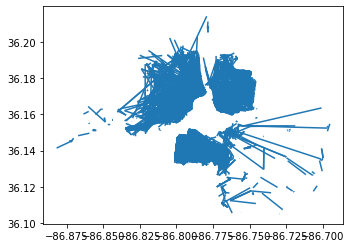

In [78]:
may_trips_by_zone.plot()

In [77]:
center = promise_zone.geometry.centroid[0]
area_center = [center.y, center.x]
print(area_center)

[36.17641188909819, -86.76416202822318]


C:\Users\16159\AppData\Local\Temp/ipykernel_24448/431885239.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = promise_zone.geometry.centroid[0]


In [81]:
map_may_trips = folium.Map(location =  area_center, zoom_start = 13)

#marker_cluster = MarkerCluster().add_to(map_6)

folium.GeoJson(promise_zone).add_to(map_may_trips)

folium.Choropleth(
    may_trips_by_zone.geometry,
    line_weight=3,
    line_color='blue').add_to(map_may_trips)

# for row_index, row_values in may_in_6.iterrows():
#    loc = [row_values['latitude'], row_values['longitude']]
 #   tool = [str(row_values['sumdid']), str(row_values['pubdatetime'])]
  #  icon=folium.Icon(color="blue",icon="map-pin", prefix='fa')
    
   # marker = folium.Marker(
    ##    location = loc, 
      #  tooltip = tool, icon = icon) 

    #marker.add_to(marker_cluster)
#map_6.save('../data/map6.html')

#display our map
map_may_trips